In [1]:
import cv2
import time
import datetime
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import Image, display
cap = cv2.VideoCapture(2) # use 0 if you only have front facing camera

In [6]:
ret, frame = cap.read() #read one frame

In [7]:
Ntime = 200
top = 500
bottom = 700
locr = 1750
locl = 1000
height = bottom-top

def getslice(frame,loc):
    return np.average(frame[top:bottom,loc],axis=-1)

def getvalue(frame,loc):
    return np.average(frame[top:bottom,loc])



ret, frame = cap.read() 
baseliner = getvalue(frame,locr)
baselinel = getvalue(frame,locl)

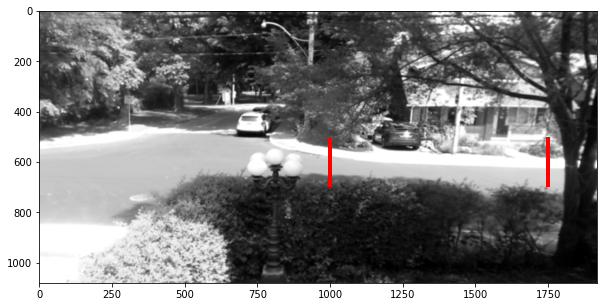

In [8]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.imshow(np.average(frame,axis=-1), interpolation = 'bicubic', cmap="gray",aspect = "auto")
ax.vlines(locr,ymin=top,ymax=bottom,color="red",lw=4)
ax.vlines(locl,ymin=top,ymax=bottom,color="red",lw=4)

In [29]:
spacetimer = np.zeros((Ntime,height))
spacetimel = np.zeros((Ntime,height))

for i in range(Ntime):
    ret, frame = cap.read() 
    spacetimer[i] = getslice(frame,locr)
    spacetimel[i] = getslice(frame,locl)

KeyboardInterrupt: 

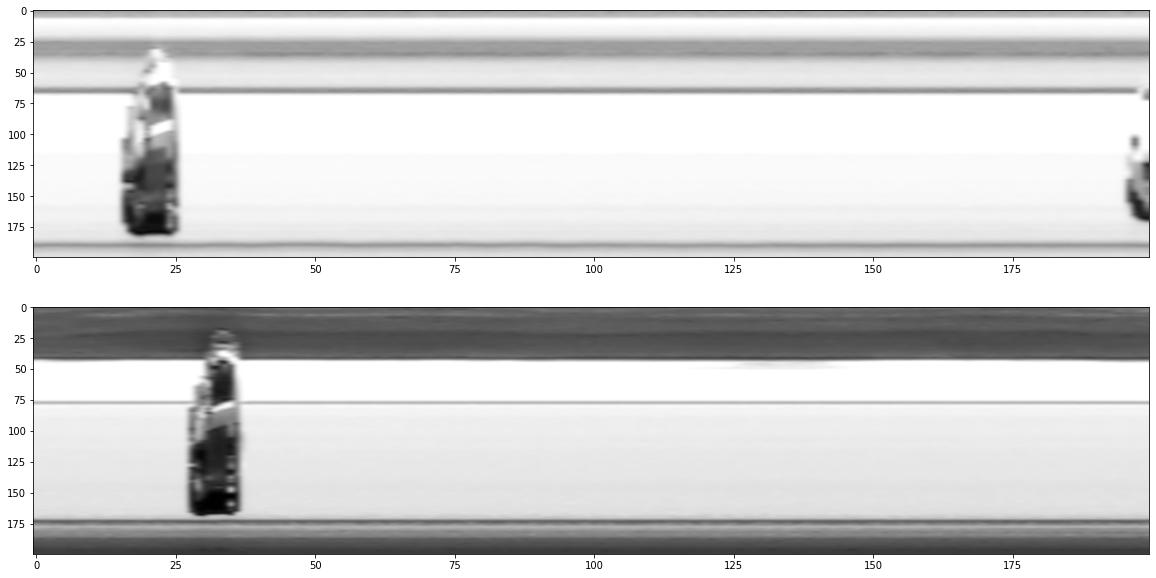

In [5]:
fig, ax = plt.subplots(2,1,figsize=(20,10))
ax[0].imshow(spacetimer.T, interpolation = 'bicubic', cmap="gray",aspect = "auto")
ax[1].imshow(spacetimel.T, interpolation = 'bicubic', cmap="gray",aspect = "auto")

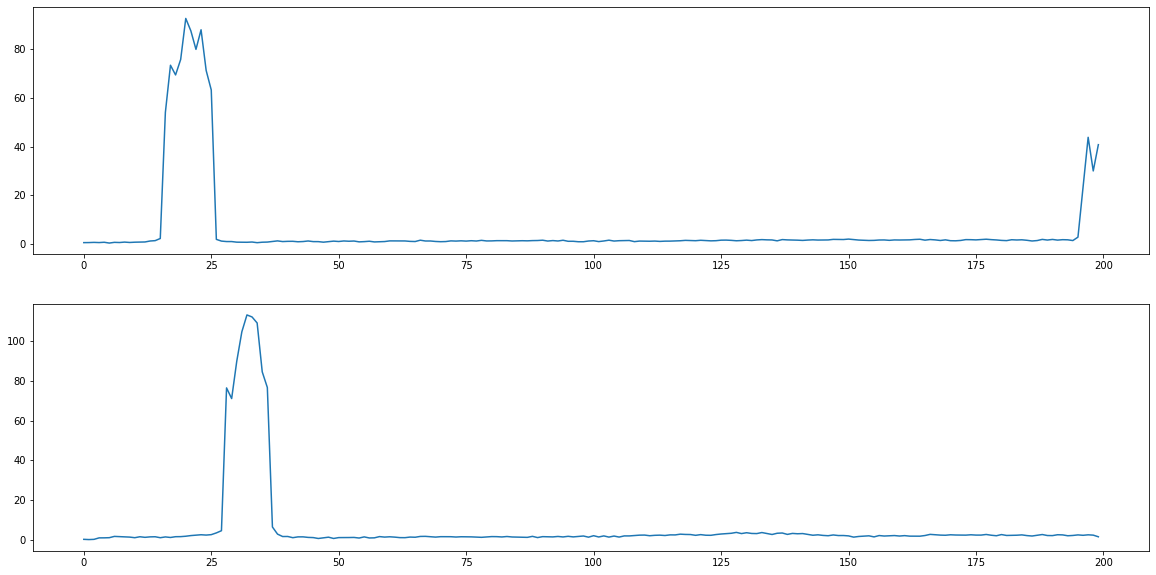

In [6]:
fig, ax = plt.subplots(2,1,figsize=(20,10))
ax[0].plot(baseliner - np.average(spacetimer,axis=1))
ax[1].plot(baselinel - np.average(spacetimel,axis=1))

In [ ]:
inprog = False
threshhold = 20
vr_avg = 0.
vl_avg = 0.
avg_N = 0
event_N = 0
try:
    while True:
        ret, frame = cap.read()
        vr = getvalue(frame,locr)
        vl = getvalue(frame,locl)

        if not inprog:
            if baseliner-vr>threshhold:
                timer = time.time()
                inprog = True
            else:
                vr_avg += vr
                vl_avg += vl
                avg_N += 1
                if avg_N == 80:
                    baseliner = vr_avg/avg_N
                    baselinel = vl_avg/avg_N
                    vr_avg = 0
                    vl_avg = 0
                    avg_N = 0
                    #print("recalibrate", baseliner,baselinel)
                
        else:
            if baselinel-vl>threshhold:
                timel = time.time()
                now = datetime.datetime.now()
                date = now.strftime("%Y-%m-%d %H:%M:%S")
                inprog = False
                vr_avg = 0
                vl_avg = 0
                avg_N = 0
                speed = 10./(timel-timer)
                
                cv2.rectangle(frame,(0,800),(2000,2000), (0,0,0),thickness=-1)
                cv2.putText(frame,"Event: %d "%event_N, (70,880), cv2.FONT_HERSHEY_PLAIN, 5, (255,255,255), 5)
                cv2.putText(frame,now.strftime("Time: %Y-%m-%d %H:%M:%S"), (70,960), cv2.FONT_HERSHEY_PLAIN, 5, (255,255,255), 5)
                cv2.putText(frame,"Speed: %.2f km/h"%speed, (70,1040), cv2.FONT_HERSHEY_PLAIN, 5, (255,255,255), 5)
                small = cv2.resize(frame, (0,0), fx=0.25, fy=0.25) 
                _,ret = cv2.imencode('.jpg', small) 
                i = Image(data=ret)
                display(i)
                
                event_N += 1

            else:
                if time.time()-timer > 2:
                    inprog = False
                    print("miss")
except KeyboardInterrupt:
    pass                

In [111]:
cap.release()